In [1]:
import anndata as ad
import scanpy.api as sc
import episcanpy.api as epi
import numpy as np
import copy
import scipy

/home/icb/chaichoompu/.local/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [3]:
sc.settings.set_figure_params(dpi=80, dpi_save=400)

In [4]:
SOURCEDIR="/home/icb/chaichoompu/Group/workspace/integration_ct_mtx_anna"
OUTDIR="/home/icb/chaichoompu/Group/workspace/Benchmarking_data_integration/data/brain_atac_fang_10x"

# Load 10x data

In [4]:
adata_10x = ad.read(SOURCEDIR+"/atac_v1_adult_brain_fresh_5k_sparse_bin_min500bins_min100cells.h5ad")

In [5]:
adata_10x

AnnData object with n_obs × n_vars = 4349 × 164259 
    obs: 'n_genes'
    var: 'chrom', 'chrom2', 'n_cells'

# Load Fang et al 2019 data

In [7]:
adata_fang = ad.read(OUTDIR+"/CEMBA180312_3B_sparse_bin.h5ad")

In [8]:
adata_fang

AnnData object with n_obs × n_vars = 14930 × 545118 

In [9]:
# To remind, there are the other files or cells as well
#CEMBA180308_3B_sparse_bin.h5ad
#CEMBA180306_2B_sparse_bin.h5ad
#CEMBA180305_2B_sparse_peak.h5ad
#CEMBA180227_1A_sparse_bin.h5ad
#CEMBA180226_1A_sparse_bin.h5ad

In [11]:
with open(SOURCEDIR+"/CEMBA180312_3B_5kbin.txt") as f:
    bin_fang = f.readlines()
bin_fang = bin_fang[1:]
bin_fang = [n[:-1].split(' * ')[-1] for n in bin_fang]
adata_fang.var_names = bin_fang

keep = []
bin_10x = adata_10x.var_names.tolist()
for n2 in bin_fang:
    if n2 in bin_10x:
        keep.append('keep')
    else:
        keep.append('discard')
        
adata_fang.var['overlap10x'] = keep
adata_fang = adata_fang[:,adata_fang.var['overlap10x']=='keep']
adata_fang

View of AnnData object with n_obs × n_vars = 14930 × 164259 
    var: 'overlap10x'

# Merge 2 datasets

In [12]:
adata = adata_fang.concatenate(adata_10x)

In [13]:
adata

AnnData object with n_obs × n_vars = 19279 × 164259 
    obs: 'batch', 'n_genes'
    var: 'overlap10x-0', 'chrom-1', 'chrom2-1', 'n_cells-1'

# To Add the label of the batches

In [14]:
batchname=copy.copy(adata.obs['batch'])
batchname

0-0        0
1-0        0
2-0        0
3-0        0
4-0        0
          ..
19986-1    1
19990-1    1
19992-1    1
19998-1    1
19999-1    1
Name: batch, Length: 19279, dtype: category
Categories (2, object): [0, 1]

In [15]:
batchname = batchname.map({ '0' : 'Fang et al. 2019', '1' : '10x Genomics' })
batchname

0-0        Fang et al. 2019
1-0        Fang et al. 2019
2-0        Fang et al. 2019
3-0        Fang et al. 2019
4-0        Fang et al. 2019
                 ...       
19986-1        10x Genomics
19990-1        10x Genomics
19992-1        10x Genomics
19998-1        10x Genomics
19999-1        10x Genomics
Name: batch, Length: 19279, dtype: category
Categories (2, object): [Fang et al. 2019, 10x Genomics]

In [16]:
adata.obs['batchname'] = batchname
adata

AnnData object with n_obs × n_vars = 19279 × 164259 
    obs: 'batch', 'n_genes', 'batchname'
    var: 'overlap10x-0', 'chrom-1', 'chrom2-1', 'n_cells-1'

In [17]:
# uncomment this line to save the data
#adata.write(OUTDIR+"/merge_10x_CEMBA180312_3B_bin_merged.h5ad")

... storing 'overlap10x-0' as categorical
... storing 'chrom-1' as categorical
... storing 'chrom2-1' as categorical


# QC for merged datasets

In [4]:
# read the intermediate files 
adata = sc.read(OUTDIR+"/merge_10x_CEMBA180312_3B_bin_merged.h5ad")

In [5]:
# Don't run it
#epi.pp.binarize(adata)
#np.max(adata.X)

In [6]:
sc.pp.filter_cells(adata, min_genes=10)

In [7]:
adata

AnnData object with n_obs × n_vars = 19277 × 164259 
    obs: 'batch', 'n_genes', 'batchname'
    var: 'overlap10x-0', 'chrom-1', 'chrom2-1', 'n_cells-1'

In [8]:
sc.pp.filter_genes(adata, min_cells=50)

In [9]:
adata

AnnData object with n_obs × n_vars = 19277 × 164259 
    obs: 'batch', 'n_genes', 'batchname'
    var: 'overlap10x-0', 'chrom-1', 'chrom2-1', 'n_cells-1', 'n_cells'

In [10]:
sc.pp.filter_genes(adata, min_cells=100)

In [11]:
adata

AnnData object with n_obs × n_vars = 19277 × 164259 
    obs: 'batch', 'n_genes', 'batchname'
    var: 'overlap10x-0', 'chrom-1', 'chrom2-1', 'n_cells-1', 'n_cells'

In [12]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.tsne(adata)
sc.tl.umap(adata)

The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../home/icb/chaichoompu/.local/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../home/icb/chaichoompu/.local/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

The keyword argum

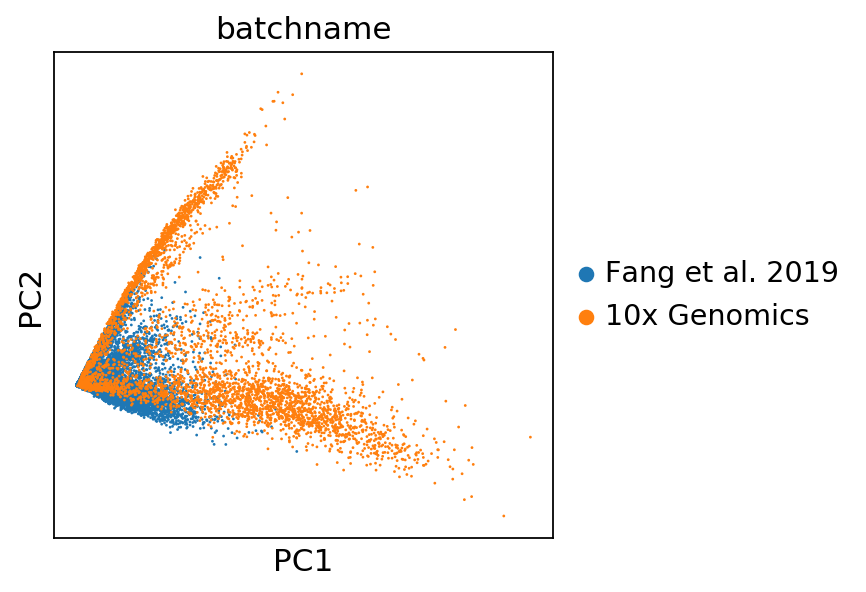

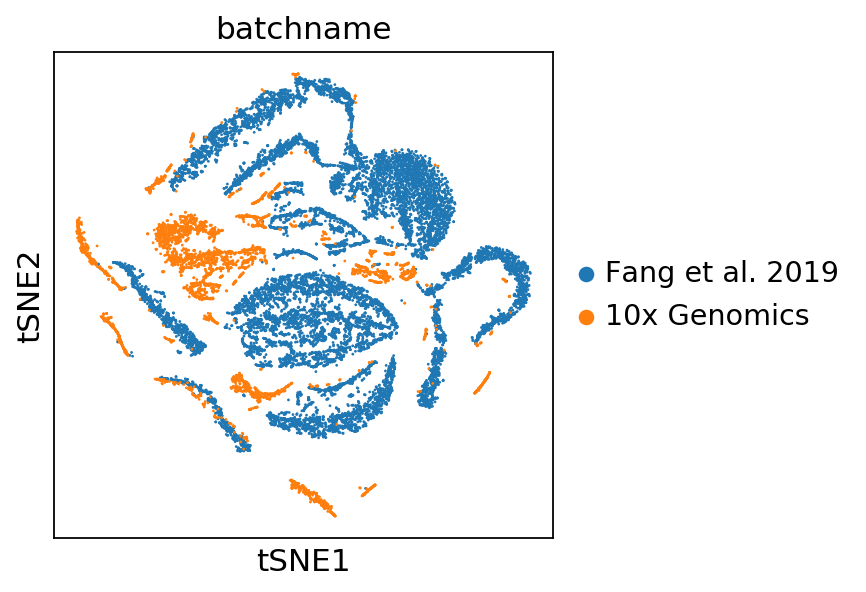

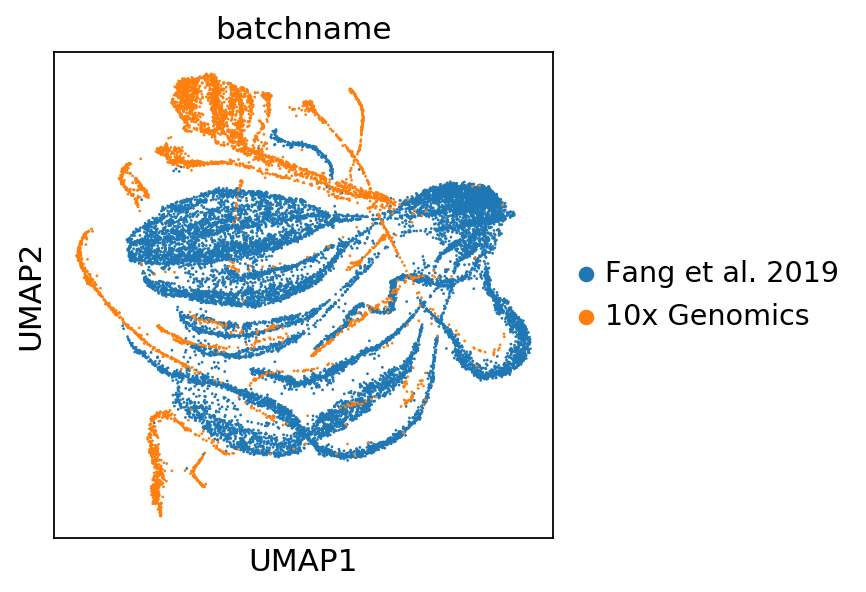

In [13]:
fplot="_brain_atac_filterRowCol.pdf"
sc.pl.pca(adata, color='batchname', save=fplot)
sc.pl.tsne(adata, color='batchname', save=fplot)
sc.pl.umap(adata, color='batchname', save=fplot)

In [14]:
sc.pp.filter_cells(adata, min_counts=1000)

In [15]:
adata

AnnData object with n_obs × n_vars = 13189 × 164259 
    obs: 'batch', 'n_genes', 'batchname', 'n_counts'
    var: 'overlap10x-0', 'chrom-1', 'chrom2-1', 'n_cells-1', 'n_cells'
    uns: 'pca', 'neighbors', 'batchname_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [16]:
adata2 = adata[:,adata.var['n_cells']>500]

In [17]:
adata2

View of AnnData object with n_obs × n_vars = 13189 × 54539 
    obs: 'batch', 'n_genes', 'batchname', 'n_counts'
    var: 'overlap10x-0', 'chrom-1', 'chrom2-1', 'n_cells-1', 'n_cells'
    uns: 'pca', 'neighbors', 'batchname_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [18]:
sc.pp.pca(adata2)
sc.pp.neighbors(adata2)

The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../home/icb/chaichoompu/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^



In [19]:
sc.tl.tsne(adata2)
sc.tl.umap(adata2)

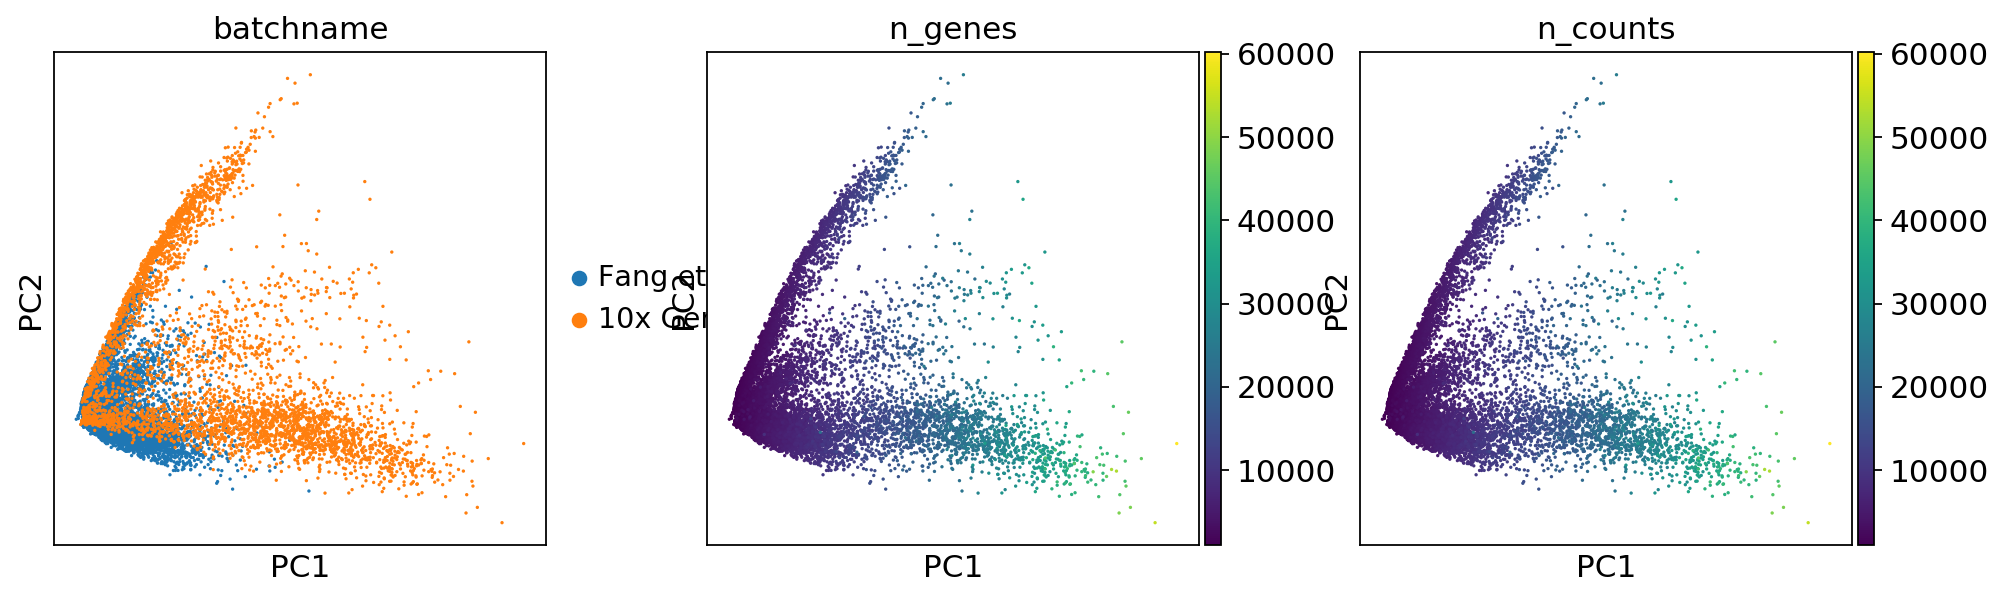

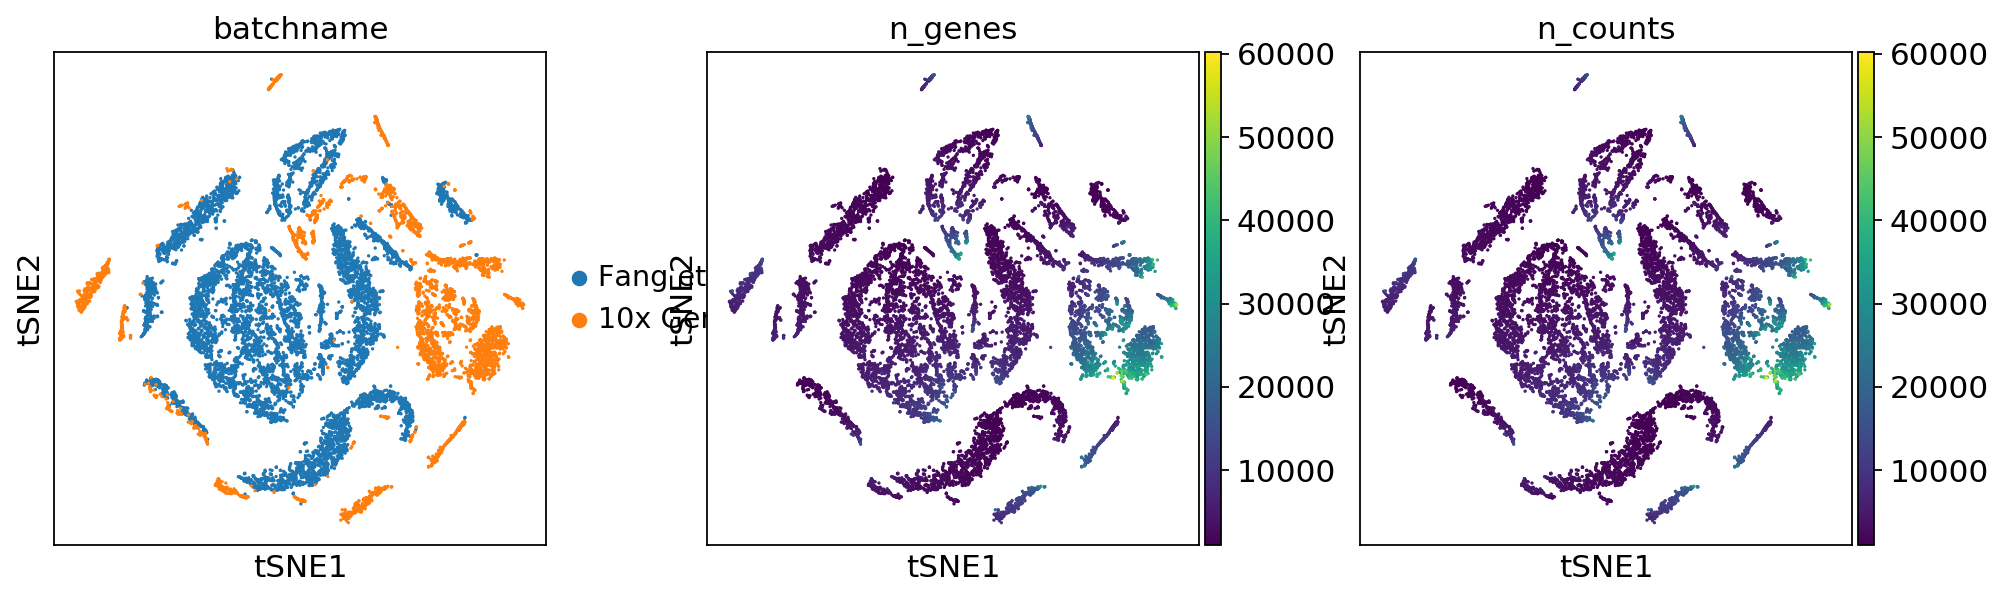

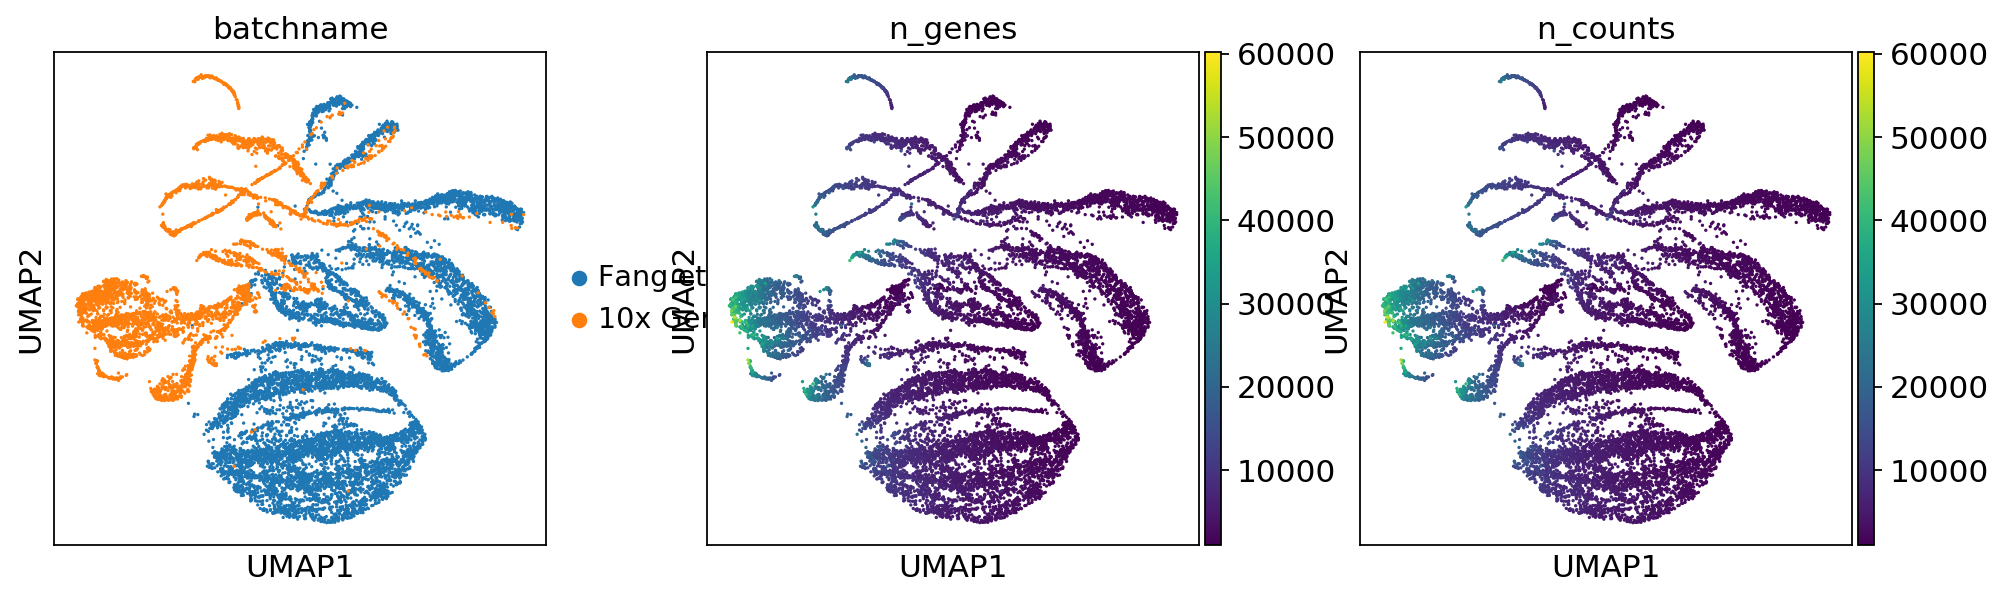

In [20]:
fplot="_brain_atac_filterRowCol_filterCountCell.pdf"
sc.pl.pca(adata2, color=['batchname', 'n_genes', 'n_counts'],save=fplot)
sc.pl.tsne(adata2, color=['batchname', 'n_genes', 'n_counts'],save=fplot)
sc.pl.umap(adata2, color=['batchname', 'n_genes', 'n_counts'],save=fplot)

In [ ]:
# uncomment this line to save the file
#adata2.write(OUTDIR+"/merge_10x_CEMBA180312_3B_bin_merged_filterRowCol_filterCountCell.h5ad")

# Regression

In [21]:
# read the intermediate files 
adata = sc.read(OUTDIR+"/merge_10x_CEMBA180312_3B_bin_merged_filterRowCol_filterCountCell.h5ad")

In [22]:
# let's regress the cells based on n_counts
# the data is already binary
np.max(adata2.X)

1.0

In [23]:
sc.pp.regress_out(adata2, 'n_counts')

In [24]:
sc.pp.pca(adata2)
sc.pp.neighbors(adata2)

The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../home/icb/chaichoompu/.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^



In [25]:

sc.tl.tsne(adata2)
sc.tl.umap(adata2)

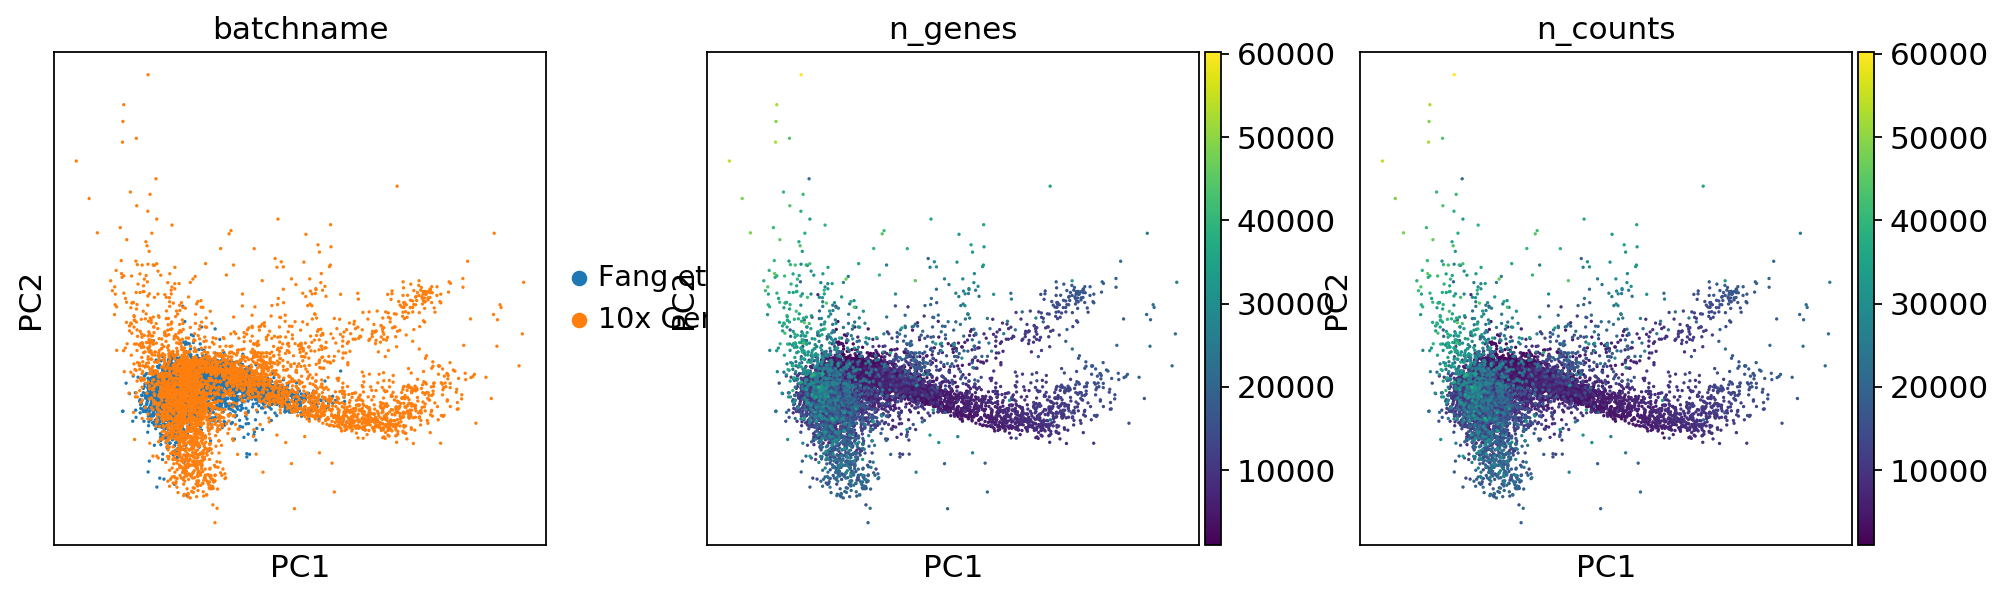

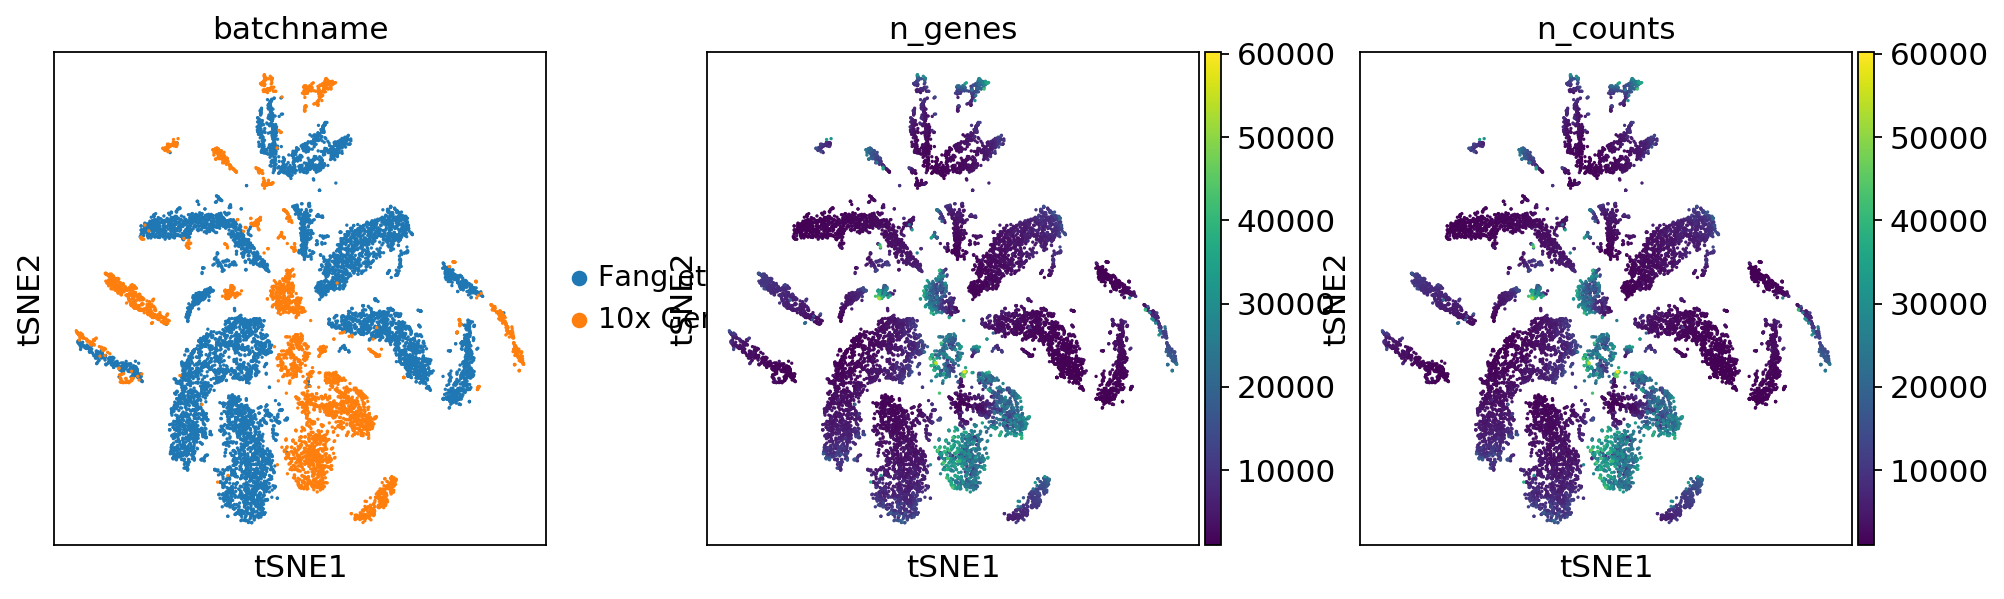

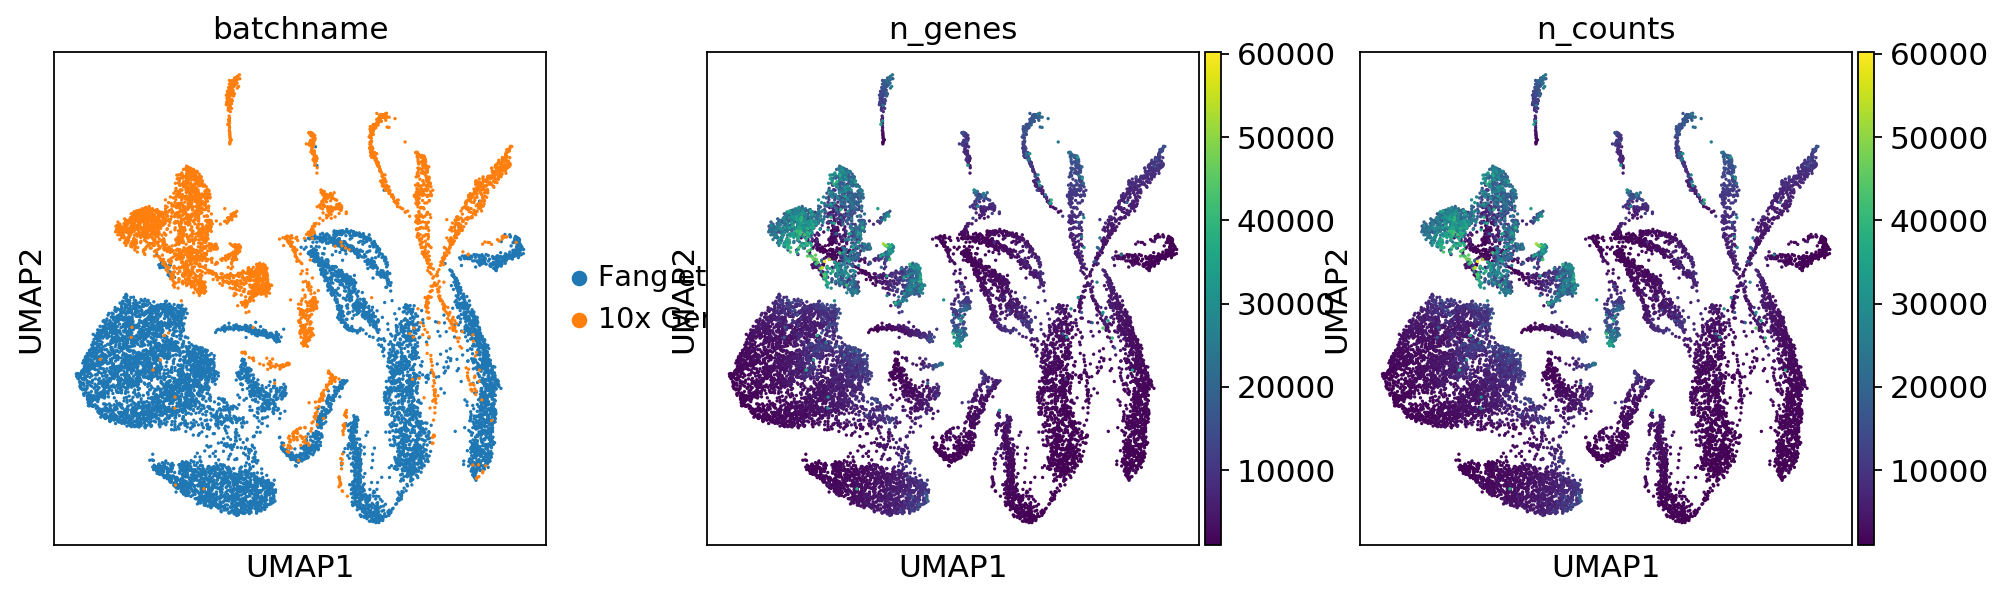

In [26]:
fplot="_brain_atac_filterRowCol_filterCountCell_regression.pdf"
sc.pl.pca(adata2, color=['batchname', 'n_genes', 'n_counts'],save=fplot)
sc.pl.tsne(adata2, color=['batchname', 'n_genes', 'n_counts'],save=fplot)
sc.pl.umap(adata2, color=['batchname', 'n_genes', 'n_counts'],save=fplot)


In [ ]:
# uncomment this line to save the file
#adata2.write(OUTDIR+"/merge_10x_CEMBA180312_3B_bin_merged_filterRowCol_filterCountCell_regression.h5ad")

In [5]:
# read the intermediate files 
adata3 = sc.read(OUTDIR+"/merge_10x_CEMBA180312_3B_bin_merged_filterRowCol_filterCountCell_regression.h5ad")

In [6]:
adata3.X = scipy.sparse.csr_matrix(adata3.X)

In [7]:
# uncomment this line to save the file
adata3.write(OUTDIR+"/merge_10x_CEMBA180312_3B_bin_merged_filterRowCol_filterCountCell_regression_Seurat.h5ad")